# Imports

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image
from sklearn.metrics import silhouette_score
import albumentations as A
from albumentations.core.composition import Compose
from albumentations.pytorch.transforms import ToTensorV2
import cv2
from tensorflow.keras.preprocessing import image


# Train/Validate/Test

In [2]:
# Paths
merged_dataset_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_dr_master_dataset/master_dataset'
combined_csv_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_dr_master_dataset/master_dataset/combined_labels.csv'

# Load the CSV file
df = pd.read_csv(combined_csv_path)

# Print the first few rows to verify
print(df.head())

# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Print the distribution to verify the split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

# ImageDataGenerator setup
img_size = (128, 128)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,       # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,   # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,         # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.2,          # Randomly zoom image
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Points outside the boundaries of the input are filled according to the given mode
)

# Load training data using flow_from_dataframe
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=merged_dataset_path,
    x_col='filename',  # Column name in the CSV file that contains the image file names
    y_col='label',  # Column name in the CSV file that contains the labels
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Load validation data using flow_from_dataframe
valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=merged_dataset_path,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Load test data using flow_from_dataframe
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=merged_dataset_path,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)


                          filename             label
0        flower_water_lily_0_1.jpg        water_lily
1  flower_great_masterwort_0_2.jpg  great_masterwort
2        flower_wallflower_0_3.jpg        wallflower
3              flower_rose_0_4.jpg              rose
4        flower_sword_lily_0_5.jpg        sword_lily
Training set size: 56641
Validation set size: 12137
Test set size: 12138
Found 56641 validated image filenames belonging to 171 classes.
Found 12137 validated image filenames belonging to 171 classes.
Found 12138 validated image filenames belonging to 171 classes.


# Unsupervised Learning

In [4]:
# Load the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x1 = Flatten()(base_model.output)
x2 = Dense(1024, activation='relu')(x1)

# Determine the number of classes
num_classes = len(train_generator.class_indices)  

# Output layer
x3 = Dense(num_classes, activation='softmax')(x2)

model = Model(inputs=base_model.input, outputs=x3)


In [23]:
# Calculate inertia (sum of squared distances) for different n_clusters
inertia = []
silhouette_scores = []
range_n_clusters = range(2, 11) 

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reduced_features)
    
    # Inertia (Elbow Method)
    inertia.append(kmeans.inertia_)
    
    # Silhouette Score
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(reduced_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)


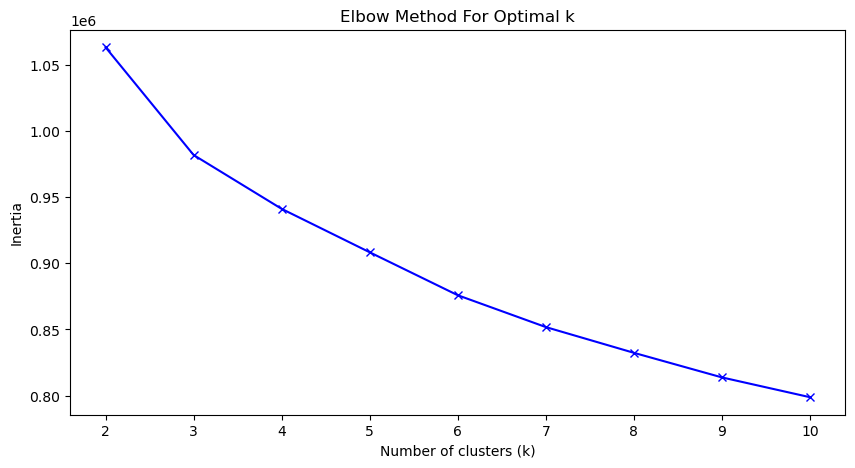

In [24]:
# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


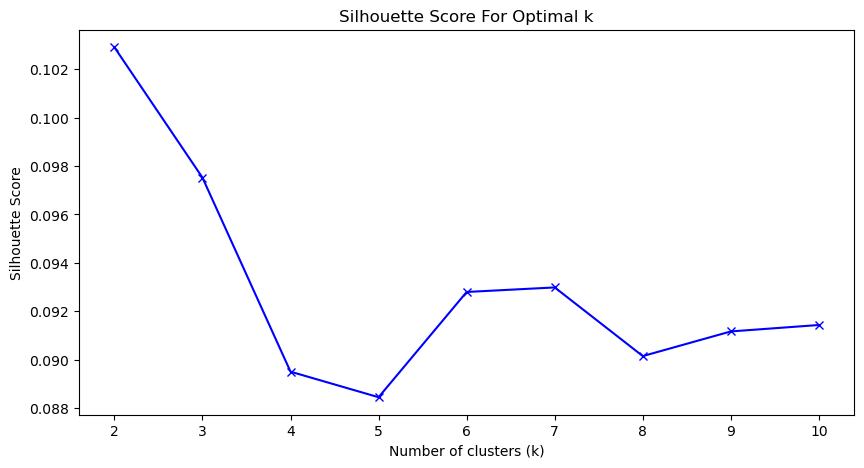

In [25]:
# Plot the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1771/1771 ━━━━━━━━━━━━━━━━━━━━ 2661s 2s/step


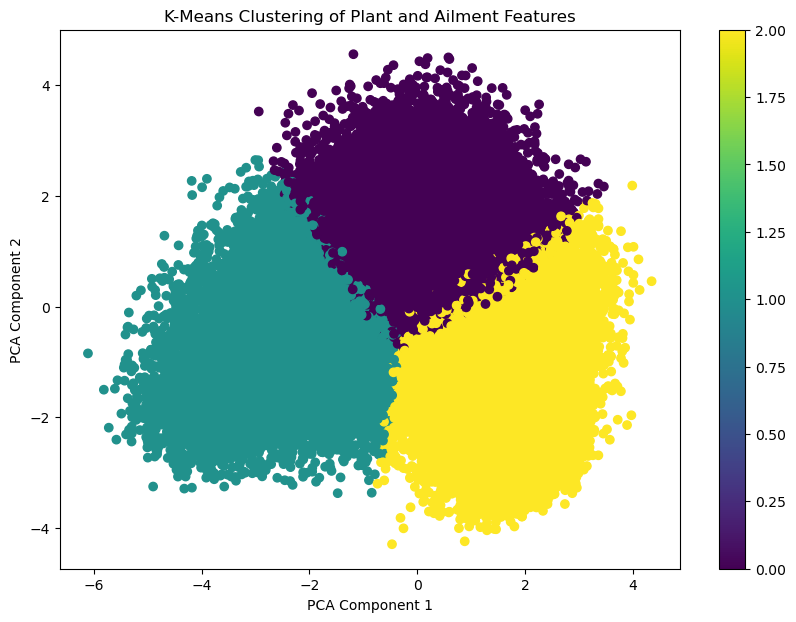

In [5]:
# Unsupervised Learning

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Extract features
feature_model = Model(inputs=model.input, outputs=model.layers[-2].output)  
features = feature_model.predict(train_generator)  

# Apply PCA
pca = PCA(n_components=30)
reduced_features = pca.fit_transform(features)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(reduced_features)

# Visualize clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('K-Means Clustering of Plant and Ailment Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


# Supervised Learning

In [6]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, validation_data=valid_generator, epochs=7)


Epoch 1/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4970 - loss: 1.8907

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3112s 2s/step - accuracy: 0.4970 - loss: 1.8904 - val_accuracy: 0.6608 - val_loss: 1.0340
Epoch 2/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3168s 2s/step - accuracy: 0.6776 - loss: 0.9567 - val_accuracy: 0.6823 - val_loss: 0.9419
Epoch 3/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3207s 2s/step - accuracy: 0.7043 - loss: 0.8411 - val_accuracy: 0.7050 - val_loss: 0.8611
Epoch 4/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3191s 2s/step - accuracy: 0.7204 - loss: 0.7887 - val_accuracy: 0.7148 - val_loss: 0.8187
Epoch 5/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3073s 2s/step - accuracy: 0.7321 - loss: 0.7423 - val_accuracy: 0.7148 - val_loss: 0.8157
Epoch 6/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3136s 2s/step - accuracy: 0.7398 - loss: 0.7157 - val_accuracy: 0.7214 - val_loss: 0.7845
Epoch 7/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3284s 2s/step - accuracy: 0.7435 - loss: 0.6909 - val_accuracy: 0.7183 - val_loss: 0.8074


In [7]:
# Evaluate the model on the validation set

val_loss, val_accuracy = model.evaluate(valid_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


380/380 ━━━━━━━━━━━━━━━━━━━━ 553s 1s/step - accuracy: 0.7189 - loss: 0.8207
Validation Loss: 0.8083425760269165
Validation Accuracy: 0.7236549258232117


In [8]:
# Unfreeze the last few layers of the VGG16 model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Re-train the model with fine-tuning
fine_tune_history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=8
)


Epoch 1/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 5893s 3s/step - accuracy: 0.7726 - loss: 0.5957 - val_accuracy: 0.7702 - val_loss: 0.6446
Epoch 2/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 6316s 4s/step - accuracy: 0.7949 - loss: 0.5095 - val_accuracy: 0.7840 - val_loss: 0.5760
Epoch 3/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 4986s 3s/step - accuracy: 0.8115 - loss: 0.4539 - val_accuracy: 0.7969 - val_loss: 0.5421
Epoch 4/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3598s 2s/step - accuracy: 0.8205 - loss: 0.4298 - val_accuracy: 0.7921 - val_loss: 0.5370
Epoch 5/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3591s 2s/step - accuracy: 0.8266 - loss: 0.4127 - val_accuracy: 0.7995 - val_loss: 0.5128
Epoch 6/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3626s 2s/step - accuracy: 0.8294 - loss: 0.3948 - val_accuracy: 0.8037 - val_loss: 0.5087
Epoch 7/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3653s 2s/step - accuracy: 0.8349 - loss: 0.3790 - val_accuracy: 0.8095 - val_loss: 0.4976


In [9]:
# Evaluate the fine-tuned model on the test set
fine_tuned_test_loss, fine_tuned_test_accuracy = model.evaluate(test_generator)
print(f"Fine-Tuned Test Loss: {fine_tuned_test_loss}")
print(f"Fine-Tuned Test Accuracy: {fine_tuned_test_accuracy}")


380/380 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.8131 - loss: 0.4618
Fine-Tuned Test Loss: 0.47195640206336975
Fine-Tuned Test Accuracy: 0.8115834593772888


# Misclassified Images

380/380 ━━━━━━━━━━━━━━━━━━━━ 564s 1s/step


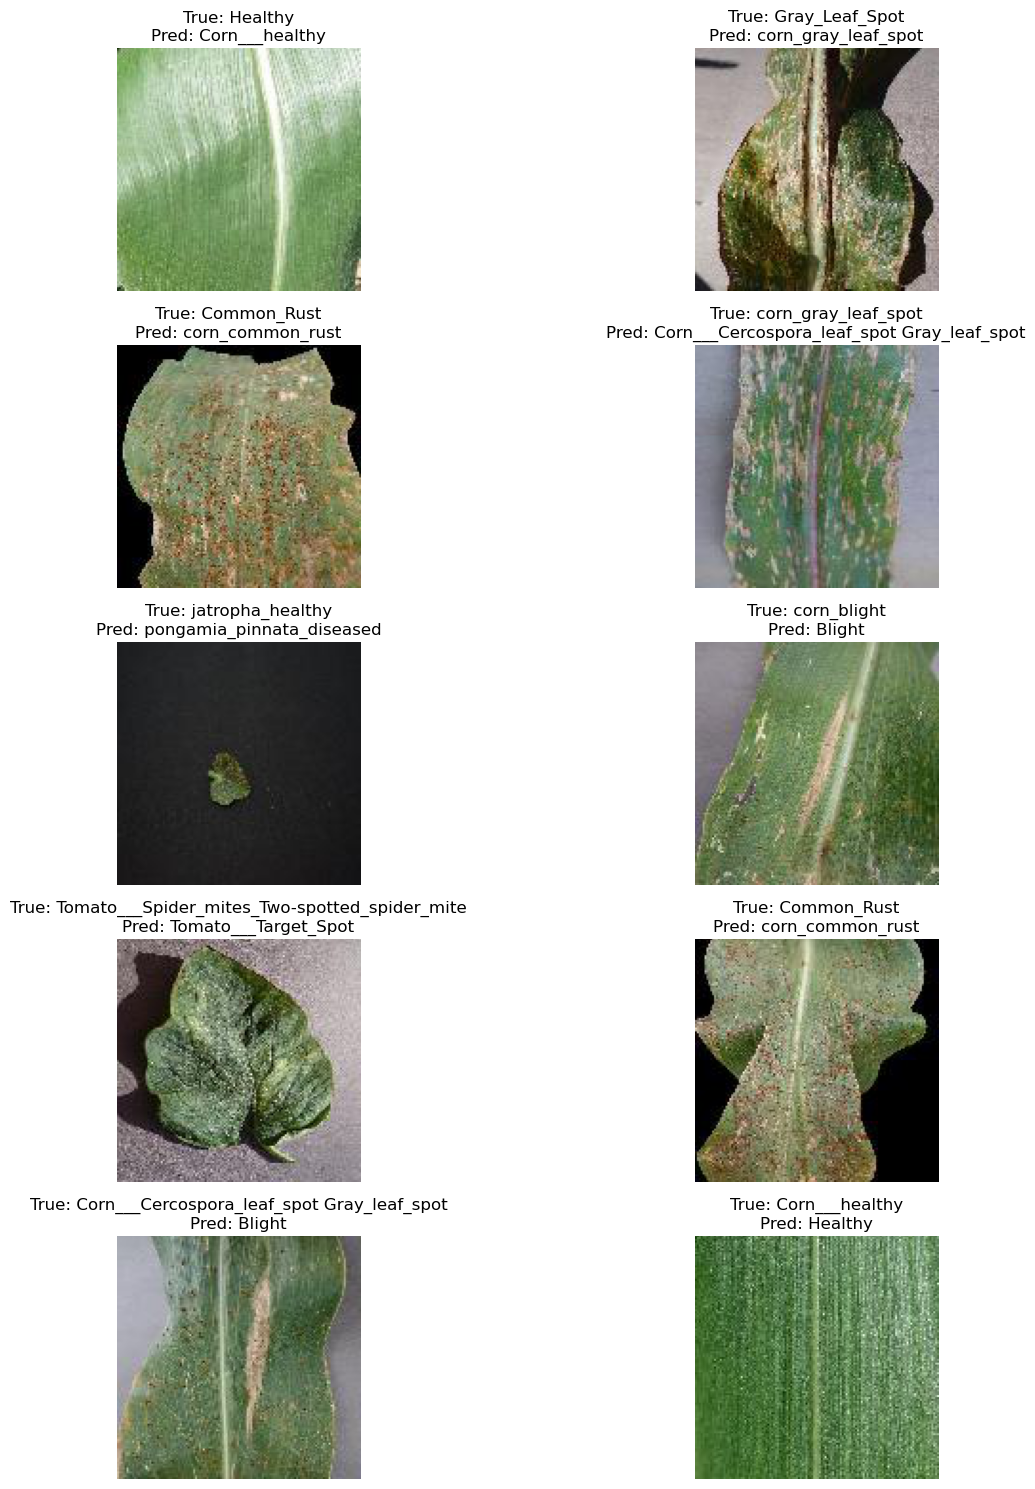

In [10]:
# Obtain predictions for the test set
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

# Identify misclassified indices
misclassified_indices = np.where(predicted_labels != true_labels)[0]

# Map class indices to class labels
class_labels = list(test_generator.class_indices.keys())

# Display some misclassified images
num_misclassified_to_display = 10  
plt.figure(figsize=(15, 15))
for i, index in enumerate(misclassified_indices[:num_misclassified_to_display]):
    plt.subplot(5, 2, i + 1)
    
    # Load and preprocess the image
    img_path = test_generator.filepaths[index]
    img = keras_image.load_img(img_path, target_size=(128, 128))
    img = keras_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Rescale if needed
    
    plt.imshow(img[0])
    plt.axis('off')
    
    true_label = class_labels[true_labels[index]]
    predicted_label = class_labels[predicted_labels[index]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")

plt.tight_layout()
plt.show()


# Predict on Unseen Images

In [20]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  
    return img_array

# Predict a single image
new_image_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/ml_model_unseen_images/tomato_late_blight.jpg'
img_array = load_and_preprocess_image(new_image_path)
prediction = model.predict(img_array)

# Map the prediction to class names
predicted_class_index = np.argmax(prediction)
predicted_class_name = list(train_generator.class_indices.keys())[predicted_class_index]

print(f"Predicted class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predicted class: Strawberry___Leaf_scorch


In [14]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0 
    return img_array

# Predict a single image
new_image_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/ml_model_unseen_images/apple_apple_scab.jpg' 
img_array = load_and_preprocess_image(new_image_path)
prediction = model.predict(img_array)

# Map the prediction to class names
predicted_class_index = np.argmax(prediction)
predicted_class_name = list(train_generator.class_indices.keys())[predicted_class_index]

print(f"Predicted class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted class: Apple___Black_rot


In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0
    return img_array

# Predict a single image
new_image_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/ml_model_unseen_images/corn_rust.jpg'
img_array = load_and_preprocess_image(new_image_path)
prediction = model.predict(img_array)

# Map the prediction to class names
predicted_class_index = np.argmax(prediction)
predicted_class_name = list(train_generator.class_indices.keys())[predicted_class_index]

print(f"Predicted class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted class: corn_gray_leaf_spot


# Albumentation

## pip installs 

In [2]:
pip install albumentations


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 10.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Albumentations Augmentation Pipeline

In [22]:
# Define Albumentations augmentation pipeline

# Paths
merged_dataset_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_dr_master_dataset/master_dataset'
combined_csv_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_dr_master_dataset/master_dataset/combined_labels.csv'

# Load the CSV file
df = pd.read_csv(combined_csv_path)

# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

img_size = (128, 128)

albumentations_transform = Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.Transpose(),
    A.OneOf([
        A.GaussNoise(),
        A.ISONoise(),
    ], p=0.2),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.2),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=0.1),
        A.PiecewiseAffine(p=0.3),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.Sharpen(),
        A.Emboss(),
        A.RandomBrightnessContrast(),
    ], p=0.3),
    A.HueSaturationValue(p=0.3),
    A.Resize(img_size[0], img_size[1]),
    ToTensorV2()
])

# Create a label to index mapping
label_mapping = {label: idx for idx, label in enumerate(train_df['label'].unique())}

# Convert labels to integers using the mapping
train_df['label_idx'] = train_df['label'].map(label_mapping)
valid_df['label_idx'] = valid_df['label'].map(label_mapping)

# Custom DataGenerator to apply Albumentations
class AlbumentationsDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, labels, batch_size, augmentations, image_dir, num_classes):
        self.image_filenames = image_filenames
        self.labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes) 
        self.batch_size = batch_size
        self.augmentations = augmentations
        self.image_dir = image_dir

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        for file_name in batch_x:
            image = cv2.imread(os.path.join(self.image_dir, file_name))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            augmented = self.augmentations(image=image)
            image = augmented['image']
            image = np.transpose(image, (1, 2, 0))
            images.append(image)

        return np.array(images), np.array(batch_y)

# Update DataGenerators with num_classes
num_classes = len(train_df['label'].unique())

A_train_generator = AlbumentationsDataGenerator(
    image_filenames=train_df['filename'].values,
    labels=train_df['label_idx'].values,
    batch_size=32,
    augmentations=albumentations_transform,
    image_dir=merged_dataset_path,
    num_classes=num_classes
)

A_valid_generator = AlbumentationsDataGenerator(
    image_filenames=valid_df['filename'].values,
    labels=valid_df['label_idx'].values, 
    batch_size=32,
    augmentations=albumentations_transform,
    image_dir=merged_dataset_path,
    num_classes=num_classes
)

# Load the base model (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x1 = Flatten()(base_model.output)
x2 = Dense(1024, activation='relu')(x1)

# Output layer with num_classes
x3 = Dense(num_classes, activation='softmax')(x2)

model = Model(inputs=base_model.input, outputs=x3)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])


/opt/anaconda3/lib/python3.11/site-packages/albumentations/core/validation.py:45: UserWarning: This augmenter is very slow. Try to use ``ElasticTransformation`` instead, which is at least 10x faster.
  original_init(self, **validated_kwargs)


In [23]:
# Train the model
model.fit(A_train_generator, validation_data=A_valid_generator, epochs=7)


Epoch 1/7


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3131s 2s/step - accuracy: 0.2208 - loss: 12.1978 - val_accuracy: 0.4509 - val_loss: 4.4071
Epoch 2/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3192s 2s/step - accuracy: 0.4748 - loss: 3.8691 - val_accuracy: 0.5149 - val_loss: 2.9483
Epoch 3/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3218s 2s/step - accuracy: 0.5383 - loss: 2.6341 - val_accuracy: 0.5508 - val_loss: 2.2776
Epoch 4/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3298s 2s/step - accuracy: 0.5773 - loss: 2.0386 - val_accuracy: 0.5856 - val_loss: 1.8721
Epoch 5/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3172s 2s/step - accuracy: 0.5987 - loss: 1.7462 - val_accuracy: 0.6083 - val_loss: 1.6526
Epoch 6/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3161s 2s/step - accuracy: 0.6253 - loss: 1.5150 - val_accuracy: 0.6312 - val_loss: 1.4692
Epoch 7/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 3182s 2s/step - accuracy: 0.6469 - loss: 1.3462 - val_accuracy: 0.6424 - val_loss: 1.3615


In [24]:
# Evaluate the model on the validation set

val_loss, val_accuracy = model.evaluate(A_valid_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


380/380 ━━━━━━━━━━━━━━━━━━━━ 611s 2s/step - accuracy: 0.6414 - loss: 1.3827
Validation Loss: 1.384387731552124
Validation Accuracy: 0.638131320476532


In [26]:
# Create a label to index mapping 
label_mapping = {label: idx for idx, label in enumerate(train_df['label'].unique())}

# Apply the label mapping to the test set
test_df['label_idx'] = test_df['label'].map(label_mapping)

# Test set: Use a similar AlbumentationsDataGenerator but without augmentations
test_transform = Compose([
    A.Resize(img_size[0], img_size[1]),  # Only resize
    ToTensorV2()  # Convert to tensor
])

# Test Data Generator
A_test_generator = AlbumentationsDataGenerator(
    image_filenames=test_df['filename'].values,
    labels=test_df['label_idx'].values, 
    batch_size=32,
    augmentations=test_transform,
    image_dir=merged_dataset_path,
    num_classes=num_classes
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(A_test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


380/380 ━━━━━━━━━━━━━━━━━━━━ 552s 1s/step - accuracy: 0.7000 - loss: 1.0788
Test Loss: 1.0874407291412354
Test Accuracy: 0.702339768409729


In [27]:
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]: 
    layer.trainable = True

# Re-compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with a lower learning rate
model.fit(A_train_generator, validation_data=A_valid_generator, epochs=3)  

# Re-evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(A_valid_generator)
print(f"Validation Loss after fine-tuning: {val_loss}")
print(f"Validation Accuracy after fine-tuning: {val_accuracy}")


Epoch 1/3
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 4100s 2s/step - accuracy: 0.6698 - loss: 1.1823 - val_accuracy: 0.6935 - val_loss: 1.0499
Epoch 2/3
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 5820s 3s/step - accuracy: 0.7218 - loss: 0.8933 - val_accuracy: 0.7216 - val_loss: 0.8919
Epoch 3/3
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 5320s 3s/step - accuracy: 0.7522 - loss: 0.7549 - val_accuracy: 0.7416 - val_loss: 0.7845
380/380 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - accuracy: 0.7460 - loss: 0.7915
Validation Loss after fine-tuning: 0.7770993709564209
Validation Accuracy after fine-tuning: 0.7448298335075378
